In [1]:
import __init__
import numpy as np
import os
import pandas as pd
from datapath_manager import ITWDataPathManager, DataPathManager
from date_time_utils import get_date_time_from_float, convert_utc_to_local_time
from trainers import MachineLearningModelTrainer, BranchNeuralNetworkTrainer
import matplotlib.pyplot as plt
from dataloader import EmbeddingDataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
import yaml, torch
from collections import Counter
from combine_features_itw import ITWFeatureCombiner
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
import shap

/home/nmduy/anaconda3/envs/stress/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_name = 'DCU_EXP2_ITW'
user_id = 'lzhou'
date = '2022-09-11'

trained_dataset_name = 'DCU_NVT_EXP2'
dl_model_name = 'branch_neural_network'
ml_model_name = 'extra_trees'
model_type = 'dependent'
signal_type = 'bvp_eda'
window_size = 60
window_shift = 0.25

In [3]:
def get_pretrained_model(model_name):
    ds_path_manager = DataPathManager(trained_dataset_name)
    user_model_saved_path = ds_path_manager.get_saved_model_path(user_id, model_name, f'{model_type}_{signal_type}', window_size, window_shift)
    user_model_saved_path = user_model_saved_path.replace(signal_type + '_', '')
    print(user_model_saved_path)
    if model_name == 'branch_neural_network':
        config_path = os.path.join(os.path.dirname(os.getcwd()), 'models', 'model_config', f'branchnn_sensor_combination_{signal_type}.yaml')
        config_dict = yaml.safe_load(open(config_path, 'r'))
        model = BranchNeuralNetworkTrainer('.', user_model_saved_path, config_dict, target_metrics=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])
    else:
        model = MachineLearningModelTrainer(user_model_saved_path, model_name, eval_mode = True, target_metrics = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])
    return model

In [4]:
dataset_path = ITWDataPathManager(dataset_name).get_dataset_path()
user_date_path = os.path.join(dataset_path, 'data', user_id, date, 'Lifelog')

user_date_feature_path = os.path.join(dataset_path, 'features', user_id, date)
# feature_path = os.path.join(user_date_feature_path, f'{signal_type}.npy')
# feature_path = os.path.join(user_date_feature_path, 'X_moment.npy')
feature_path = os.path.join(user_date_feature_path, 'X.npy')
# gt_path = os.path.join(user_date_feature_path, 'y_moment.npy')
gt_path = os.path.join(user_date_feature_path, 'y.npy')
metadata_path = os.path.join(user_date_feature_path, 'metadata.csv')
feature_names = [line.strip() for line in open('feature_names.txt', 'r').readlines()]
labels_path = os.path.join(user_date_feature_path, 'datetime_info.npy')

In [5]:
metadata = pd.read_csv(metadata_path)

In [6]:
# features = np.nan_to_num(np.load(feature_path))
# gt = np.zeros(features.shape[0])
labels = np.load(labels_path)
features = np.nan_to_num(np.load(feature_path)[:, :66])
gt = np.load(gt_path)
test_dataloader = EmbeddingDataLoader(features, gt)

/mnt/DATA/nvtu/PhD/stress_data/DCU_NVT_EXP2/models/60_0.25/dependent_bvp_eda/branch_neural_network/lzhou_branch_neural_network_dependent_60_0.25.pth
LOAD PRETRAINED MODEL
{'accuracy': 0.4008564594345041, 'balanced_accuracy': 0.41507045253686536, 'precision': 0.037616977378232996, 'recall': 0.43092290377039955, 'f1': 0.06919375607111393}


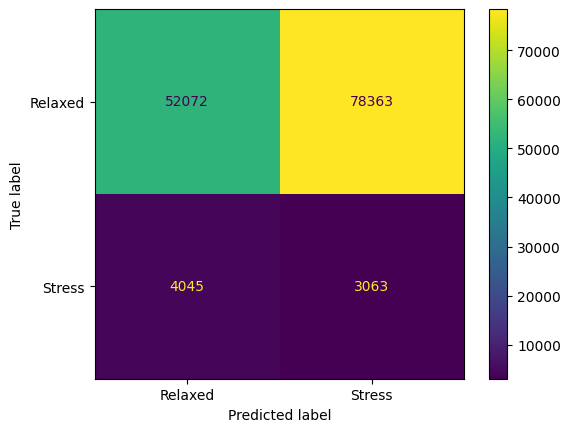

In [7]:
dl_model = get_pretrained_model(dl_model_name)
y_pred = dl_model.predict(test_dataloader)
print(dl_model.predict_and_evaluate(test_dataloader))
ConfusionMatrixDisplay.from_predictions(gt, y_pred, display_labels=['Relaxed', 'Stress'])

/mnt/DATA/nvtu/PhD/stress_data/DCU_NVT_EXP2/models/60_0.25/dependent_bvp_eda/extra_trees/lzhou_extra_trees_dependent_60_0.25.joblib
LOAD PRETRAINED MODEL
{'accuracy': 0.49504518586914636, 'balanced_accuracy': 0.4223643660743964, 'precision': 0.03610280220843192, 'recall': 0.34130557118739446, 'f1': 0.06529843213781036}


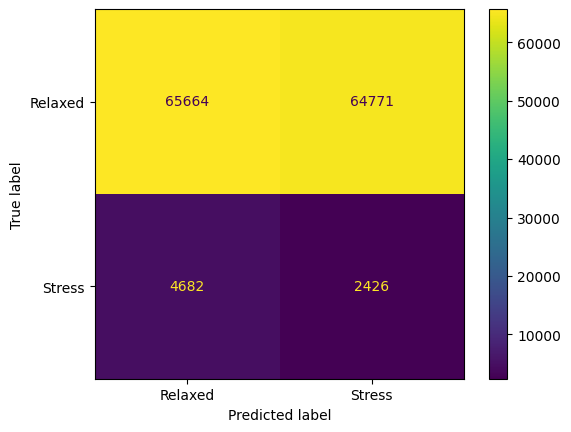

In [8]:
ml_model = get_pretrained_model(ml_model_name)
y_pred = ml_model.predict(test_dataloader)
print(ml_model.predict_and_evaluate(test_dataloader))
ConfusionMatrixDisplay.from_predictions(gt, y_pred, display_labels=['Relaxed', 'Stress'])

In [9]:
fp = [i for i in range(len(y_pred)) if y_pred[i] == 1 and gt[i] == 0]
# fp_data = metadata.loc[metadata.index[fp]]
# fp_data.to_csv(f'{user_id}_{date}_fp_{signal_type}.csv')
fp_data = labels[fp]

IndexError: index 702 is out of bounds for axis 0 with size 691

In [ ]:
fp_data

array(['20220912_081845_000', '20220912_081929_000',
       '20220912_082119_000', '20220912_082141_000',
       '20220912_082247_000', '20220912_082331_000',
       '20220912_082438_000', '20220912_082500_000',
       '20220912_082853_000', '20220912_083021_000',
       '20220912_083045_000', '20220912_083107_000',
       '20220912_083213_000', '20220912_083618_000',
       '20220912_083702_000', '20220912_090745_000',
       '20220912_091211_000', '20220912_093137_000',
       '20220912_145922_000', '20220912_153555_000',
       '20220912_153617_000', '20220912_154148_000',
       '20220912_162307_000', '20220912_162922_000',
       '20220912_163324_000', '20220912_163348_000',
       '20220912_163529_000', '20220912_163551_000',
       '20220912_163719_000', '20220912_163741_000',
       '20220912_173733_000', '20220912_173901_000',
       '20220912_173923_000', '20220912_173945_000',
       '20220912_174029_000', '20220912_174538_000',
       '20220912_192327_000', '20220912_192349

In [ ]:
explainer = shap.TreeExplainer(ml_model.model)
shap_values = explainer.shap_values(features[:1000])

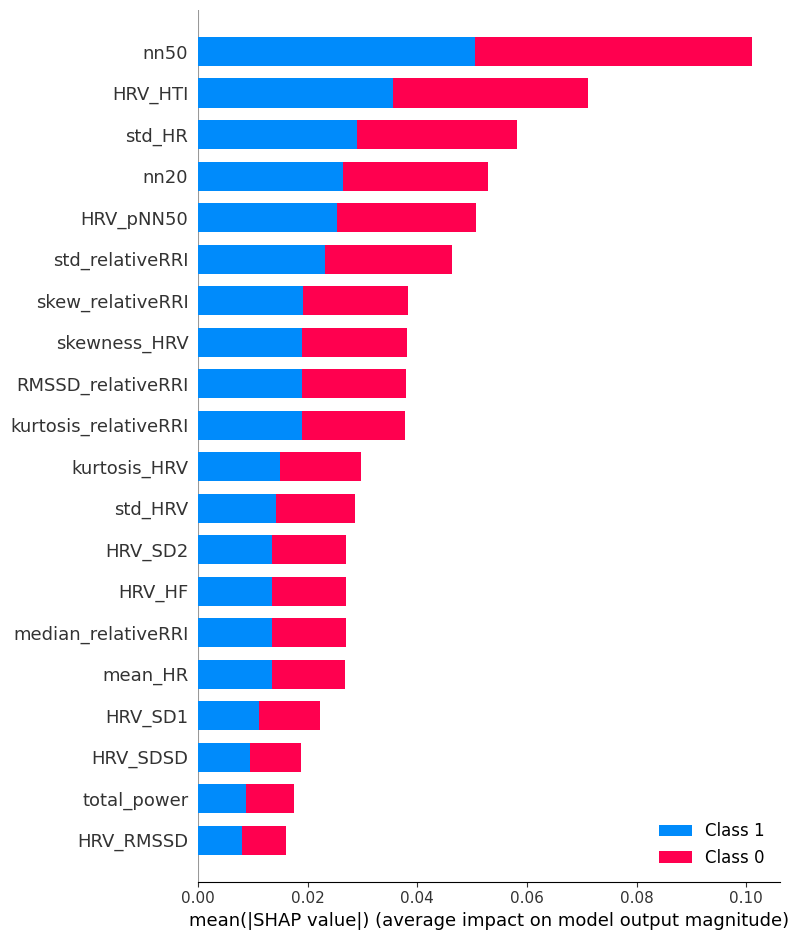

In [ ]:
shap.summary_plot(shap_values, features[:1000], feature_names=feature_names[:66])

In [ ]:
shap_value = explainer.shap_values(features[0])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_value[1], features[0], feature_names=feature_names[:30])